In [1]:
import numpy as np
import math
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
import cartopy
import cartopy.crs as ccrs
import metpy.calc as mpcalc
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
import pop_tools 
import matplotlib.path as mpath
import dask

import utils
import pandas as pd
import numpy as np
import cmocean

import matplotlib.gridspec as gridspec
import matplotlib.colors as colors

### Read in phyto and zoo data, then make dominant type maps and zonal mean plots

In [2]:
ocn_vars = ['spC','diatC','diazC','coccoC','mesozooC','microzooC']
case = 'g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.4p2z.002branch'
path = '/glade/campaign/cesm/development/bgcwg/projects/CESM2-OMIP2-like-4p2z-run/'+case+'/ocn/proc/tseries/month_1'
keep_vars = ocn_vars +['dz','KMT','time_bound']

In [3]:
%%time

ds = xr.Dataset()

for v in ocn_vars:  
    print(v)
    files = f'{path}/{case}.pop.h.{v}.195801-202112.nc'

    dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                   drop_variables=["transport_components", "transport_regions"], combine='nested',decode_times=True)

    ds = xr.merge((ds, dsv))

ds = ds.drop([v for v in ds.variables if v not in keep_vars]).squeeze()

spC
diatC
diazC
coccoC
mesozooC
microzooC
CPU times: user 2.81 s, sys: 138 ms, total: 2.95 s
Wall time: 6.09 s


In [4]:
ds["time"] = ds.time_bound.compute().mean(dim="d2")

In [5]:
monthly_time_dim = ds["time"]

### Read in fish

In [6]:
case = 'g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.4p2z.002branch'

path = '/glade/campaign/cesm/development/bgcwg/projects/CESM2-OMIP2-like-4p2z-run/'+case+'/feisty/'

file = f'{path}/FEISTY_monthly_002branch.nc'
        
ds_fish = xr.open_dataset(file)

In [7]:
ds_fish['time'] = monthly_time_dim

### Spin up a Dask cluster

In [8]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=1,
        memory='20GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=20GB',
        project='NCGD0011',
        walltime='02:00:00',
        interface='ext',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })
    client = Client(cluster)
    return cluster, client

In [9]:
cluster, client = get_ClusterClient()
cluster.scale(8) 
client

Client Scheduler: tcp://128.117.208.82:39147 Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kristenk/proxy/35499/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


### Resample and trim to 1980 to 2005

In [10]:
ds_ann_fosi = ds.resample({'time':'A'}).mean(dim='time').compute()

In [11]:
ds_ann_fish = ds_fish.resample({'time':'A'}).mean(dim='time').compute()

In [12]:
ds_ann_fosi['time'][22:48]

<xarray.DataArray 'time' (time: 26)>
array([cftime.DatetimeNoLeap(1980, 12, 31, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(1981, 12, 31, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(1982, 12, 31, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(1983, 12, 31, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(1984, 12, 31, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(1985, 12, 31, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(1986, 12, 31, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(1987, 12, 31, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(1988, 12, 31, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(1989, 12, 31, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(1990, 12, 31, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(1991, 12, 31, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(1992, 12, 31, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(1993, 12, 31, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(1994, 12, 31, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(1995, 12, 31, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(1996, 12, 31, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(1997, 12, 31, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(1998, 12, 31, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(1999, 12, 31, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2000, 12, 31, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2001, 12, 31, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2002, 12, 31, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2003, 12, 31, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2004, 12, 31, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2005, 12, 31, 0, 0, 0, 0)], dtype=object)
Coordinates:
  * time     (time) object 1980-12-31 00:00:00 ... 2005-12-31 00:00:00

In [13]:
ds_ann_fosi = ds_ann_fosi.isel(time=slice(22,48))

In [14]:
ds_ann_fish = ds_ann_fish.isel(time=slice(22,48))

### Make a mean over these years

In [15]:
ds_mean_fish = ds_ann_fish.mean(dim='time').load()

In [44]:
ds_mean_fosi = ds_ann_fosi.mean(dim='time').load()

In [45]:
ds_grid = pop_tools.get_grid('POP_gx1v7')
lons = ds_grid.TLONG
lats = ds_grid.TLAT
area = ds_grid.TAREA

In [46]:
ds_mean_fish

<xarray.Dataset>
Dimensions:     (fish: 8, group: 9, nlat: 384, nlon: 320)
Coordinates:
  * fish        (fish) object 'Sf' 'Sp' 'Sd' 'Mf' 'Mp' 'Md' 'Lp' 'Ld'
  * group       (group) object 'Sf' 'Sp' 'Sd' 'Mf' ... 'Lp' 'Ld' 'benthic_prey'
  * nlat        (nlat) int64 0 1 2 3 4 5 6 7 ... 376 377 378 379 380 381 382 383
  * nlon        (nlon) int64 0 1 2 3 4 5 6 7 ... 312 313 314 315 316 317 318 319
Data variables:
    biomass     (group, nlat, nlon) float64 nan nan nan nan ... nan nan nan nan
    fish_yield  (fish, nlat, nlon) float64 nan nan nan nan ... nan nan nan nan
    production  (fish, nlat, nlon) float64 nan nan nan nan ... nan nan nan nan

In [47]:
tot_forage = ds_mean_fish.biomass.sel(group='Sf') + ds_mean_fish.biomass.sel(group='Mf')
tot_pelagic = ds_mean_fish.biomass.sel(group='Sp') + ds_mean_fish.biomass.sel(group='Mp') + ds_mean_fish.biomass.sel(group='Lp')
tot_demersal = ds_mean_fish.biomass.sel(group='Sd') + ds_mean_fish.biomass.sel(group='Md') + ds_mean_fish.biomass.sel(group='Ld')

tot_fish = tot_forage + tot_pelagic + tot_demersal

### Annual mean fish biomass maps

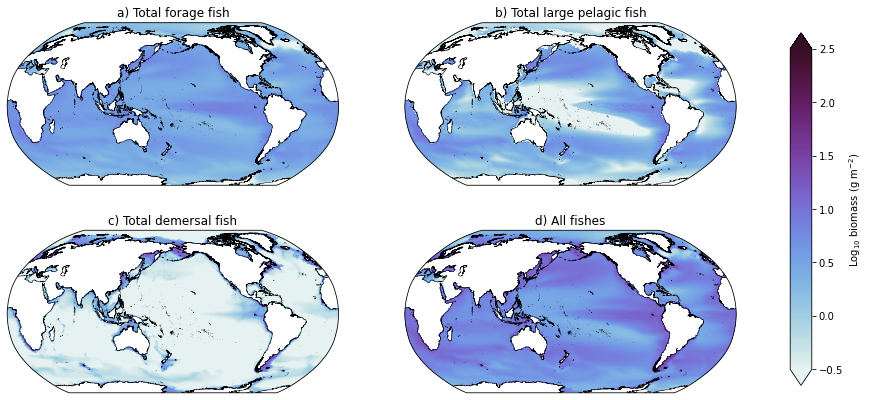

In [48]:
fig = plt.figure(figsize=(15,7))

tot_fish_group_label_dict = {'forage':
                             {'data': tot_forage,
                              'label': "a) Total forage fish"},
                             'pelagic':
                             {'data': tot_pelagic,
                              'label': "b) Total large pelagic fish"},
                             'demersal':
                             {'data': tot_demersal,
                              'label': "c) Total demersal fish"},
                             'total':
                             {'data': tot_fish,
                              'label': "d) All fishes"}
                            }

plot_index = 1

for i in tot_fish_group_label_dict.keys():
    ax = fig.add_subplot(2,2,plot_index, projection=ccrs.Robinson(central_longitude=180))
    plot_index += 1

    ax.set_title(tot_fish_group_label_dict[i]['label'], loc='center')
    lon, lat, field = utils.adjust_pop_grid(lons, lats, np.log10(tot_fish_group_label_dict[i]['data'])) 

    pc=ax.pcolormesh(lon, lat, field, 
                     vmin=-0.5, vmax=2.5, 
                     cmap=cmocean.cm.dense,
                     transform=ccrs.PlateCarree())

    ax.coastlines('10m',linewidth=0.5)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar1 = fig.colorbar(pc, cax=cbar_ax,extend='both',label='Log$_{10}$ biomass (g m$^{-2}$)')

fig.savefig('/glade/work/kristenk/figs/fig_fish_mean_maps_hires.png', bbox_inches='tight', dpi=300, format='png');


#### now for each variable, take times 10 to make a proper depth integral and adjust attributes

In [49]:
for var in ocn_vars:
    
    ds_mean_fosi[var] = (ds_mean_fosi[var] * 10.).sum(dim='z_t_150m')
    ds_mean_fosi[var].attrs['units'] = 'mmol/m2'

In [51]:
for var in ocn_vars:
    
    ds_mean_fosi[var] = ds_mean_fosi[var] * 0.001 * 12.
    ds_mean_fosi[var].attrs['units'] = 'g/m2'

#### calc dominant phyto

In [52]:
tot_phyto = ds_mean_fosi.spC + ds_mean_fosi.diatC + ds_mean_fosi.coccoC + ds_mean_fosi.diazC

sp_frac = ds_mean_fosi.spC/tot_phyto
diat_frac =  ds_mean_fosi.diatC/tot_phyto
cocco_frac = ds_mean_fosi.coccoC/tot_phyto
diaz_frac = ds_mean_fosi.diazC/tot_phyto

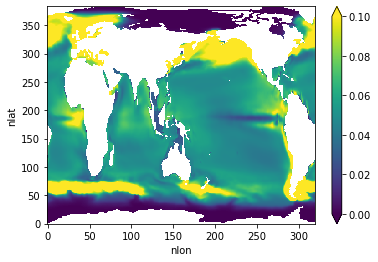

In [53]:
cocco_frac.plot(vmin=0,vmax=0.1)

In [54]:
tmp = xr.concat((sp_frac, diat_frac, cocco_frac, diaz_frac),dim='phyto')
dom_phyto = tmp.argmax(dim='phyto', skipna=False).where(ds_grid.REGION_MASK >0)

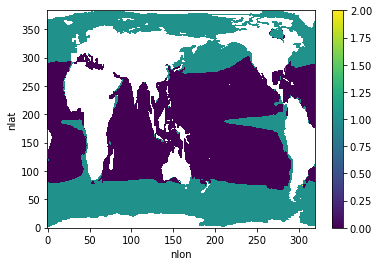

In [55]:
dom_phyto.plot()

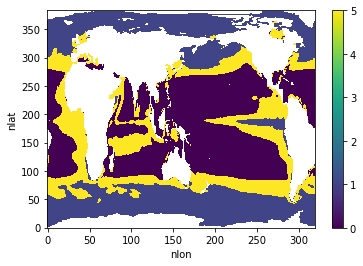

In [56]:
max_fracs = tmp.max(dim='phyto', skipna=False).where(ds_grid.REGION_MASK >0)
dom_phyto.where(max_fracs>0.6,other=5).where(ds_grid.REGION_MASK > 0).plot()

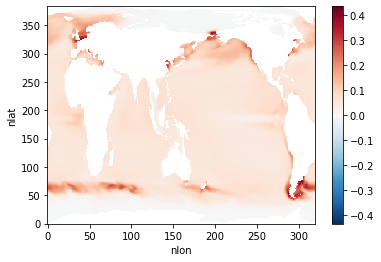

In [57]:
cocco_frac.where(ds_grid.REGION_MASK > 0).plot()

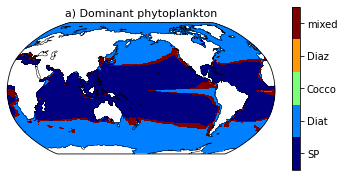

In [58]:
fig = plt.figure(figsize=(6,3))

##############

ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=180.0))
colorbar_specs = {'ticks' : np.arange(0,5,1)}
ax.set_title('a) Dominant phytoplankton', fontsize=11)
#ax.set_extent([-180,180,-90,90],ccrs.Robinson(central_longitude=180.0))


lon, lat, field = utils.adjust_pop_grid(lons, lats,  dom_phyto.where(max_fracs>0.5,other=4).where(ds_grid.REGION_MASK > 0))
pc=ax.pcolormesh(lon, lat, field, cmap=plt.cm.get_cmap('jet',5),vmin=-0.5,vmax=4.5,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

# lon,lat,field = utils.adjust_pop_grid(lons, lats, cocco_frac.where(ds_grid.REGION_MASK > 0))
# cs1 = ax.contour(lon,lat,field, colors='lawngreen',
#     levels = [0.2],
#     linewidths = 0.5,
#     transform=ccrs.PlateCarree())


# lon,lat,field = utils.adjust_pop_grid(lons, lats, diaz_frac)
# cs = ax.contour(lon,lat,field, colors='orange',
#     levels = [0.05],
#     linewidths = 0.5,
#     transform=ccrs.PlateCarree())

cbar = fig.colorbar(pc, ax=ax,**colorbar_specs)
cbar.ax.set_yticklabels(['SP', 'Diat', 'Cocco', 'Diaz','mixed']);



### calc dominant zoo

In [59]:
microzoo_frac = ds_mean_fosi.microzooC/(ds_mean_fosi.microzooC + ds_mean_fosi.mesozooC)
mesozoo_frac =  ds_mean_fosi.mesozooC/(ds_mean_fosi.microzooC + ds_mean_fosi.mesozooC)

In [60]:
### combine fractions into one dimension
tmp = xr.concat((microzoo_frac, mesozoo_frac),dim='zoo')

max_fracs_zoo = tmp.max(dim='zoo', skipna=False).where(ds_grid.REGION_MASK >0)
dom_zoo = tmp.argmax(dim='zoo', skipna=False).where(ds_grid.REGION_MASK >0)

### calc dominant fish

In [61]:
all_year_categories = xr.Dataset()

tot_forage = ds_mean_fish.biomass.sel(group='Sf') + ds_mean_fish.biomass.sel(group='Mf')
tot_pelagic = ds_mean_fish.biomass.sel(group='Sp') + ds_mean_fish.biomass.sel(group='Mp') + ds_mean_fish.biomass.sel(group='Lp')
tot_demersal = ds_mean_fish.biomass.sel(group='Sd') + ds_mean_fish.biomass.sel(group='Md')+ ds_mean_fish.biomass.sel(group='Ld')
tot_fish = tot_forage + tot_pelagic + tot_demersal

all_year_categories["tot_forage"] = tot_forage
all_year_categories["tot_pelagic"] = tot_pelagic
all_year_categories["tot_demersal"] = tot_demersal
all_year_categories["tot_fish"] = tot_fish

all_year_categories = all_year_categories.drop_vars("group")

In [62]:
all_year_categories["mixed"] = xr.where(np.logical_and(
    all_year_categories.tot_forage/all_year_categories.tot_fish<0.5,
    np.logical_and(
    all_year_categories.tot_pelagic/all_year_categories.tot_fish<0.5,
    all_year_categories.tot_demersal/all_year_categories.tot_fish<0.5)), 1, 0)

all_year_categories["f_dom"] = xr.where(np.logical_and(
    all_year_categories.mixed == 0, 
    all_year_categories.tot_forage/all_year_categories.tot_fish>=0.5), 2, 0)    

all_year_categories["d_dom"] = xr.where(np.logical_and(
    all_year_categories.mixed == 0, 
    all_year_categories.tot_demersal/all_year_categories.tot_fish>=0.5), 3, 0)  

all_year_categories["p_dom"] = xr.where(np.logical_and(
    all_year_categories.mixed == 0, 
    all_year_categories.tot_pelagic/all_year_categories.tot_fish>=0.5), 4, 0) 

all_year_categories["pf_dom"] = xr.where(np.logical_and(
    all_year_categories.mixed == 1,
    all_year_categories.tot_demersal/all_year_categories.tot_fish<0.2), 1, 0)

all_year_categories["df_dom"] = xr.where(np.logical_and(
    all_year_categories.mixed == 1, 
    all_year_categories.tot_pelagic/all_year_categories.tot_fish<0.2), 1, 0)

all_year_categories["dom_categories"] = (all_year_categories.f_dom + all_year_categories.mixed + 
                                         all_year_categories.d_dom + all_year_categories.p_dom)


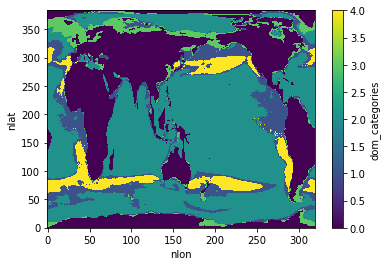

In [63]:
all_year_categories["dom_categories"].plot()

### Make right side of the figure - dominance maps

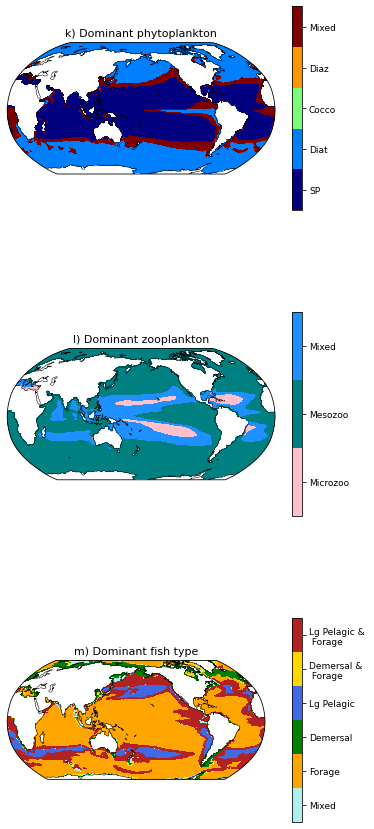

In [65]:
fig = plt.figure(figsize=(6,15))

##############
ax = fig.add_subplot(3,1,1, projection=ccrs.Robinson(central_longitude=180))
colorbar_specs = {'ticks' : np.arange(0,5,1)}
ax.set_title('k) Dominant phytoplankton', fontsize=11)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  dom_phyto.where(max_fracs>0.55,other=4).where(ds_grid.REGION_MASK > 0))
pc=ax.pcolormesh(lon, lat, field, cmap=plt.cm.get_cmap('jet',5),vmin=-0.5,vmax=4.5,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

# lon,lat,field = utils.adjust_pop_grid(lons, lats, cocco_frac)
# cs = ax.contour(lon,lat,field, colors='lawngreen',
#     levels = [0.25],
#     linewidths = 0.5,
#     transform=ccrs.PlateCarree())


# lon,lat,field = utils.adjust_pop_grid(lons, lats, diaz_frac)
# cs = ax.contour(lon,lat,field, colors='orange',
#     levels = [0.05],
#     linewidths = 0.5,
#     transform=ccrs.PlateCarree())

cbar = fig.colorbar(pc, ax=ax,**colorbar_specs)
cbar.ax.set_yticklabels(['SP', 'Diat', 'Cocco', 'Diaz','Mixed'], fontsize=9);

ax = fig.add_subplot(3,1,2, projection=ccrs.Robinson(central_longitude=180))
colorbar_specs = {'ticks' : np.arange(0,3,1)}
ax.set_title('l) Dominant zooplankton', fontsize=11)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  dom_zoo.where(max_fracs_zoo>0.55,other=2).where(ds_grid.REGION_MASK > 0))

colorlist = [ 'pink', 'teal','dodgerblue']

cmap = matplotlib.colors.LinearSegmentedColormap.from_list('zoos', colorlist, N=3)
#pc=ax.pcolormesh(lon, lat, field, cmap=plt.cm.get_cmap('Paired',3),vmin=-0.5,vmax=2.5,transform=ccrs.PlateCarree())
pc=ax.pcolormesh(lon, lat, field, cmap=cmap,vmin=-0.5,vmax=2.5,transform=ccrs.PlateCarree())

ax.coastlines('110m',linewidth=0.5)
cbar = fig.colorbar(pc, ax=ax,**colorbar_specs)
cbar.ax.set_yticklabels(['Microzoo', 'Mesozoo','Mixed'], fontsize=9);

############################# dominant fish
ax = fig.add_subplot(3,1,3, projection=ccrs.Robinson(central_longitude=180))
colorbar_specs = {'ticks' : np.arange(0,4,1)}
ax.set_title('m) Dominant fish type', fontsize=11)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  all_year_categories["dom_categories"].where(ds_grid.REGION_MASK > 0))
lon, lat, field2 = utils.adjust_pop_grid(lons, lats, all_year_categories["df_dom"].where(ds_grid.REGION_MASK > 0))
lon, lat, field3 = utils.adjust_pop_grid(lons, lats, all_year_categories["pf_dom"].where(ds_grid.REGION_MASK > 0))

colorlist = ['paleturquoise', 'orange', 'green', 'royalblue', 'gold', 'firebrick']

cmap = matplotlib.colors.LinearSegmentedColormap.from_list('fish_cats', colorlist, N=6)


#ax.add_feature(cartopy.feature.LAND, zorder=3, edgecolor='k', facecolor="white")
pc=ax.pcolormesh(lon, lat, field, cmap=cmap, vmin=0.5, vmax=6.5,
                 transform=ccrs.PlateCarree())

pc1=ax.contourf(lon, lat, field2,levels=[0.5,1.5],transform=ccrs.PlateCarree(),colors=colorlist[4])
pc2=ax.contourf(lon, lat, field3,levels=[0.5,1.5],transform=ccrs.PlateCarree(),colors=colorlist[5])

ax.coastlines('110m',linewidth=0.5)
cbar = fig.colorbar(pc, ax=ax, ticks=[1,2,3,4,5,6], pad=0.08)
cbar.ax.set_yticklabels(['Mixed', 'Forage', 'Demersal', 'Lg Pelagic','Demersal & \n Forage', 'Lg Pelagic & \n Forage'], fontsize=9) 


fig.subplots_adjust(wspace=0.07,hspace=0.5)

fig.savefig('/glade/work/kristenk/figs/dominant_types_x1.png', bbox_inches='tight', dpi=300, format='png');

### Make biomass maps for the left side of the figure

In [66]:
tot_fish_group_label_dict = {'forage':
                             {'data': tot_forage,
                              'label': "a) Total forage fish"},
                             'pelagic':
                             {'data': tot_pelagic,
                              'label': "b) Total large pelagic fish"},
                             'demersal':
                             {'data': tot_demersal,
                              'label': "c) Total demersal fish"},
                             'total':
                             {'data': tot_fish,
                              'label': "d) All fishes"}
                            }


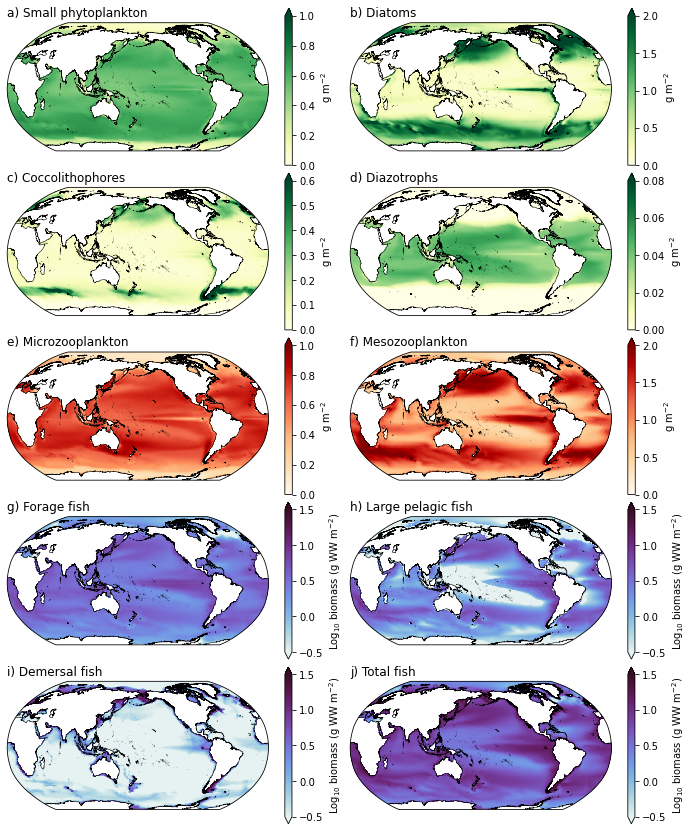

In [69]:
fig = plt.figure(figsize=(12,15))

################# phytoplankton
ax = fig.add_subplot(5,2,1, projection=ccrs.Robinson(central_longitude=180))

ax.set_title('a) Small phytoplankton', loc='left')
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds_mean_fosi.spC.where(ds_grid.REGION_MASK>0)) 

pc=ax.pcolormesh(lon, lat, field, 
                 vmin=0, vmax=1, 
                 #cmap=cmocean.cm.algae,
                 cmap='YlGn',
                 transform=ccrs.PlateCarree())

ax.coastlines('10m',linewidth=0.5)

fig.colorbar(pc,extend='max', label='g m$^{-2}$');

############
ax = fig.add_subplot(5,2,2, projection=ccrs.Robinson(central_longitude=180))

ax.set_title('b) Diatoms', loc='left')
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds_mean_fosi.diatC.where(ds_grid.REGION_MASK>0)) 

pc=ax.pcolormesh(lon, lat, field, 
                 vmin=0, vmax=2.0, 
                 #cmap=cmocean.cm.algae,
                 cmap='YlGn',
                 transform=ccrs.PlateCarree())

ax.coastlines('10m',linewidth=0.5)

fig.colorbar(pc,extend='max', label='g m$^{-2}$');

############
ax = fig.add_subplot(5,2,3, projection=ccrs.Robinson(central_longitude=180))

ax.set_title('c) Coccolithophores', loc='left')
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds_mean_fosi.coccoC.where(ds_grid.REGION_MASK>0)) 

pc=ax.pcolormesh(lon, lat, field, 
                 vmin=0, vmax=0.6, 
                 #cmap=cmocean.cm.algae,
                 cmap='YlGn',
                 transform=ccrs.PlateCarree())

ax.coastlines('10m',linewidth=0.5)

fig.colorbar(pc,extend='max', label='g m$^{-2}$');

############
ax = fig.add_subplot(5,2,4, projection=ccrs.Robinson(central_longitude=180))

ax.set_title('d) Diazotrophs', loc='left')
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds_mean_fosi.diazC.where(ds_grid.REGION_MASK>0)) 

pc=ax.pcolormesh(lon, lat, field, 
                 vmin=0, vmax=0.08, 
                 #cmap=cmocean.cm.algae,
                 cmap='YlGn',
                 transform=ccrs.PlateCarree())

ax.coastlines('10m',linewidth=0.5)

fig.colorbar(pc,extend='max', label='g m$^{-2}$');

####################### zooplankton
ax = fig.add_subplot(5,2,5, projection=ccrs.Robinson(central_longitude=180))

ax.set_title('e) Microzooplankton', loc='left')
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds_mean_fosi.microzooC.where(ds_grid.REGION_MASK>0)) 

pc=ax.pcolormesh(lon, lat, field, 
                 vmin=0, vmax=1.0, 
                 #cmap=cmocean.cm.amp,
                 cmap='OrRd',
                 transform=ccrs.PlateCarree())

ax.coastlines('10m',linewidth=0.5)

fig.colorbar(pc,extend='max', label='g m$^{-2}$');

############
ax = fig.add_subplot(5,2,6, projection=ccrs.Robinson(central_longitude=180))

ax.set_title('f) Mesozooplankton', loc='left')
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds_mean_fosi.mesozooC.where(ds_grid.REGION_MASK>0)) 

pc=ax.pcolormesh(lon, lat, field, 
                 vmin=0, vmax=2, 
                 #cmap=cmocean.cm.amp,
                 cmap='OrRd',
                 transform=ccrs.PlateCarree())

ax.coastlines('10m',linewidth=0.5)

fig.colorbar(pc,extend='max', label='g m$^{-2}$');

####################### fish

ax = fig.add_subplot(5,2,7, projection=ccrs.Robinson(central_longitude=180))

ax.set_title('g) Forage fish', loc='left')
lon, lat, field = utils.adjust_pop_grid(lons, lats, np.log10(tot_fish_group_label_dict['forage']['data'])) 

pc=ax.pcolormesh(lon, lat, field, 
                 vmin=-0.5, vmax=1.5, 
                 cmap=cmocean.cm.dense,
                 transform=ccrs.PlateCarree())

ax.coastlines('10m',linewidth=0.5)
cbar1 = fig.colorbar(pc, extend='both',label='Log$_{10}$ biomass (g WW m$^{-2}$)')
###########
ax = fig.add_subplot(5,2,8, projection=ccrs.Robinson(central_longitude=180))

ax.set_title('h) Large pelagic fish', loc='left')
lon, lat, field = utils.adjust_pop_grid(lons, lats, np.log10(tot_fish_group_label_dict['pelagic']['data'])) 

pc=ax.pcolormesh(lon, lat, field, 
                 vmin=-0.5, vmax=1.5, 
                 cmap=cmocean.cm.dense,
                 transform=ccrs.PlateCarree())

ax.coastlines('10m',linewidth=0.5)
cbar1 = fig.colorbar(pc, extend='both',label='Log$_{10}$ biomass (g WW m$^{-2}$)')
###########
ax = fig.add_subplot(5,2,9, projection=ccrs.Robinson(central_longitude=180))

ax.set_title('i) Demersal fish', loc='left')
lon, lat, field = utils.adjust_pop_grid(lons, lats, np.log10(tot_fish_group_label_dict['demersal']['data'])) 

pc=ax.pcolormesh(lon, lat, field, 
                 vmin=-0.5, vmax=1.5, 
                 cmap=cmocean.cm.dense,
                 transform=ccrs.PlateCarree())

ax.coastlines('10m',linewidth=0.5)
cbar1 = fig.colorbar(pc, extend='both',label='Log$_{10}$ biomass (g WW m$^{-2}$)')
#########
ax = fig.add_subplot(5,2,10, projection=ccrs.Robinson(central_longitude=180))

ax.set_title('j) Total fish', loc='left')
lon, lat, field = utils.adjust_pop_grid(lons, lats, np.log10(tot_fish_group_label_dict['total']['data'])) 

pc=ax.pcolormesh(lon, lat, field, 
                 vmin=-0.5, vmax=1.5, 
                 cmap=cmocean.cm.dense,
                 transform=ccrs.PlateCarree())

ax.coastlines('10m',linewidth=0.5)
cbar1 = fig.colorbar(pc, extend='both',label='Log$_{10}$ biomass (g WW m$^{-2}$)')


fig.subplots_adjust(wspace=0.05, hspace=0.05)

fig.savefig('/glade/work/kristenk/figs/all_biomass_glob_maps_x1.png', bbox_inches='tight', dpi=300, format='png');

### Next steps:

#### 1) download right and left sides of figure
#### 2) put them together using Illustrator

### Zonal means (not part of manuscript)

In [71]:
ds_mean_fosi['nlat'] = ds_grid.nlat
ds_mean_fosi['nlon'] = ds_grid.nlon
area['nlat'] = ds_grid.nlat
area['nlon'] = ds_grid.nlon

In [72]:
ones = np.full((384,320),1,dtype=int)
ones = xr.DataArray(ones,dims=('nlat','nlon'))
ones = ones.where(ds_grid.REGION_MASK>0)

In [74]:
ds_zonal_x1 = xr.Dataset()
ds_zonal_x1_sd = xr.Dataset()

for var in ocn_vars:
    
    da = np.full((57),np.nan)
    da_sd = np.full((57),np.nan)
    
    i=0
    
    for lat_band in np.arange(-78,90,3):
        
        mask = ones.where(lats >= lat_band).where(lats < (lat_band+3))
        masked_area = area.where(mask==1)   

        masked_fosi = ds_mean_fosi[var].where(mask==1)

        weighted_mean_fosi = (masked_fosi * masked_area).sum(dim=('nlon','nlat')) / masked_area.sum(dim=('nlon','nlat'))
        weighted_st_dev = math.sqrt(((masked_fosi - weighted_mean_fosi)**2 * masked_area).sum(dim=('nlon','nlat'))/(masked_area.sum(dim=('nlon','nlat'))))
    
        da[i] = weighted_mean_fosi.values
        da_sd[i] = weighted_st_dev
        #print(lat_band, weighted_mean_fosi.values)
        i = i + 1
        
    ds_zonal_x1[var] = xr.DataArray(da,dims=('lat'))
    ds_zonal_x1_sd[var] = xr.DataArray(da_sd,dims=('lat'))
        
ds_zonal_x1['lat'] = np.arange(-78,93,3)

In [75]:
ds_zonal_x1_sd['lat'] = np.arange(-78,93,3)

In [86]:
#do forage fish

da = np.full((57),np.nan)
da_sd = np.full((57),np.nan)

i=0
    
for lat_band in np.arange(-78,90,3):

    mask = ones.where(lats >= lat_band).where(lats < (lat_band+3))
    masked_area = area.where(mask==1)   

    masked_fosi = tot_forage.where(mask==1)

    weighted_mean_fosi = (masked_fosi * masked_area).sum(dim=('nlon','nlat')) / masked_area.sum(dim=('nlon','nlat'))
    weighted_st_dev = math.sqrt(((masked_fosi - weighted_mean_fosi)**2 * masked_area).sum(dim=('nlon','nlat'))/(masked_area.sum(dim=('nlon','nlat'))))
    
    da[i] = weighted_mean_fosi.values
    da_sd[i] = weighted_st_dev
    #print(lat_band, weighted_mean_fosi.values)
    i = i + 1
        
ds_zonal_x1['forage_fish'] = xr.DataArray(da,dims=('lat'))
ds_zonal_x1_sd['forage_fish'] = xr.DataArray(da_sd,dims=('lat'))

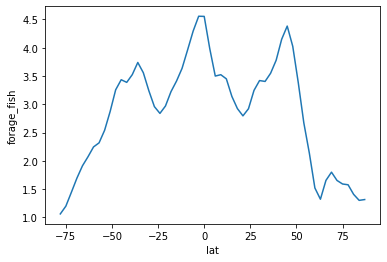

In [87]:
ds_zonal_x1['forage_fish'].plot()

In [79]:
#do pelagic fish

da = np.full((57),np.nan)
da_sd = np.full((57),np.nan)

i=0
    
for lat_band in np.arange(-78,90,3):

    mask = ones.where(lats >= lat_band).where(lats < (lat_band+3))
    masked_area = area.where(mask==1)   

    masked_fosi = tot_pelagic.where(mask==1)

    weighted_mean_fosi = (masked_fosi * masked_area).sum(dim=('nlon','nlat')) / masked_area.sum(dim=('nlon','nlat'))
    weighted_st_dev = math.sqrt(((masked_fosi - weighted_mean_fosi)**2 * masked_area).sum(dim=('nlon','nlat'))/(masked_area.sum(dim=('nlon','nlat'))))
    

    da[i] = weighted_mean_fosi.values
    da_sd[i] = weighted_st_dev
    #print(lat_band, weighted_mean_fosi.values)
    i = i + 1
        
ds_zonal_x1['pelagic_fish'] = xr.DataArray(da,dims=('lat'))
ds_zonal_x1_sd['pelagic_fish'] = xr.DataArray(da_sd,dims=('lat'))

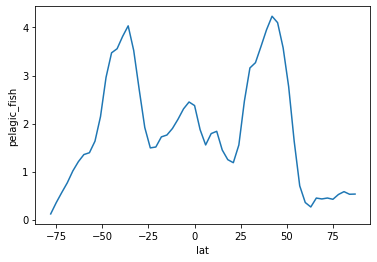

In [80]:
ds_zonal_x1['pelagic_fish'].plot()

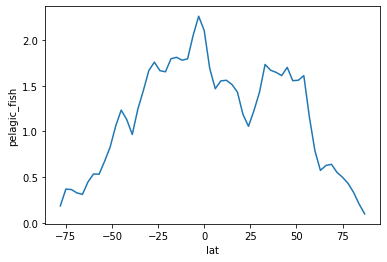

In [81]:
ds_zonal_x1_sd['pelagic_fish'].plot()

In [82]:
tot_demersal = tot_demersal.where(tot_demersal < 10000.)
tot_demersal = tot_demersal.where(tot_demersal > -100.)

In [84]:
#do demersal fish

da = np.full((57),np.nan)
da_sd = np.full((57),np.nan)
    
i=0
    
for lat_band in np.arange(-78,90,3):

    mask = ones.where(lats >= lat_band).where(lats < (lat_band+3))
    masked_area = area.where(mask==1)   

    masked_fosi = tot_demersal.where(mask==1)

    weighted_mean_fosi = (masked_fosi * masked_area).sum(dim=('nlon','nlat')) / masked_area.sum(dim=('nlon','nlat'))
    
    weighted_st_dev = math.sqrt(((masked_fosi - weighted_mean_fosi)**2 * masked_area).sum(dim=('nlon','nlat'))/(masked_area.sum(dim=('nlon','nlat'))))
    
    da[i] = weighted_mean_fosi
    da_sd[i] = weighted_st_dev                                                                            
    #print(lat_band, weighted_mean_fosi.values)
    i = i + 1
        
ds_zonal_x1['demersal_fish'] = xr.DataArray(da,dims=('lat'))
ds_zonal_x1_sd['demersal_fish'] = xr.DataArray(da_sd,dims=('lat'))

[Text(0, 0.5, 'Latitude'), Text(0.5, 0, 'Biomass (g m$^{-2}$)')]

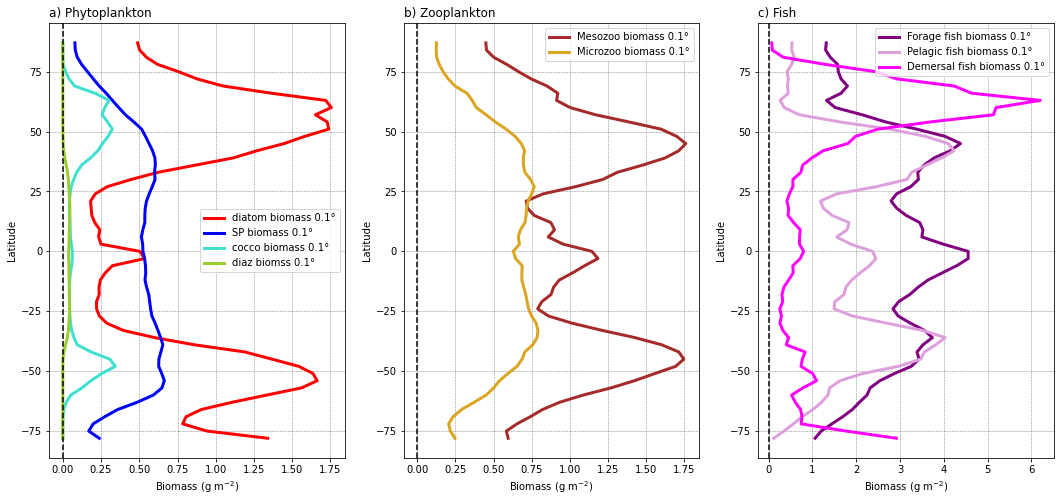

In [88]:
fig = plt.figure(figsize=(18,8))

ax = fig.add_subplot(1,3,1)
ax.set_title('a) Phytoplankton', loc='left')
ax.plot(ds_zonal_x1.diatC, ds_zonal_x1.lat, label='diatom biomass 0.1°', linewidth=3, color='red')
ax.plot(ds_zonal_x1.spC, ds_zonal_x1.lat, label='SP biomass 0.1°', linewidth=3, color='blue')
ax.plot(ds_zonal_x1.coccoC, ds_zonal_x1.lat, label='cocco biomass 0.1°', linewidth=3, color='turquoise')
ax.plot(ds_zonal_x1.diazC, ds_zonal_x1.lat, label='diaz biomss 0.1°', linewidth=3, color='yellowgreen')

# ax.plot(ds_zonal_x1.photoC_diat_zint*0.01*86400, ds_zonal_x1.lat, label='diatom NPP x1', linewidth=1, color='red')
# ax.plot(ds_zonal_x1.photoC_sp_zint*0.01*86400, ds_zonal_x1.lat, label='SP NPP x1', linewidth=1, color='blue')
# ax.plot(ds_zonal_x1.photoC_cocco_zint*0.01*86400, ds_zonal_x1.lat, label='cocco NPP x1', linewidth=1, color='turquoise')
# ax.plot(ds_zonal_x1.photoC_diaz_zint*0.01*86400, ds_zonal_x1.lat, label='diaz NPP x1', linewidth=1, color='yellowgreen')

ax.grid(color = 'gray', linestyle = '--', linewidth = 0.5)

ax.legend()
ax.axvline(0, linestyle='--',color='black')
ax.set(ylabel='Latitude',xlabel='Biomass (g m$^{-2}$)')

ax = fig.add_subplot(1,3,2)
ax.set_title('b) Zooplankton', loc='left')
ax.plot(ds_zonal_x1.mesozooC, ds_zonal_x1.lat, label='Mesozoo biomass 0.1°', linewidth=3, color='brown')
ax.plot(ds_zonal_x1.microzooC, ds_zonal_x1.lat, label='Microzoo biomass 0.1°', linewidth=3, color='goldenrod')

ax.grid(color = 'gray', linestyle = '--', linewidth = 0.5)

ax.legend()
ax.axvline(0, linestyle='--',color='black')
ax.set(ylabel='Latitude',xlabel='Biomass (g m$^{-2}$)')

ax = fig.add_subplot(1,3,3)
ax.set_title('c) Fish', loc='left')
ax.plot(ds_zonal_x1.forage_fish, ds_zonal_x1.lat, label='Forage fish biomass 0.1°', linewidth=3, color='purple')
ax.plot(ds_zonal_x1.pelagic_fish, ds_zonal_x1.lat, label='Pelagic fish biomass 0.1°', linewidth=3, color='plum')
ax.plot(ds_zonal_x1.demersal_fish, ds_zonal_x1.lat, label='Demersal fish biomass 0.1°', linewidth=3, color='magenta')

ax.grid(color = 'gray', linestyle = '--', linewidth = 0.5)

ax.legend()
ax.axvline(0, linestyle='--',color='black')
ax.set(ylabel='Latitude',xlabel='Biomass (g m$^{-2}$)')


#fig.savefig('/glade/work/kristenk/figs/zonal_phytozoofish_prod.png', bbox_inches='tight', dpi=300, format='png');

[Text(0, 0.5, 'Latitude'), Text(0.5, 0, 'Biomass (g m$^{-2}$)')]

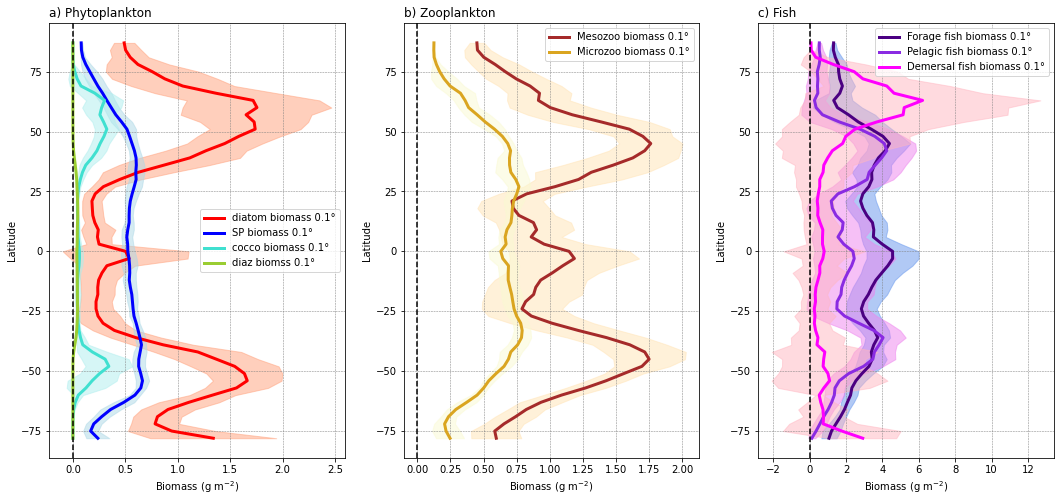

In [92]:
fig = plt.figure(figsize=(18,8))

ax = fig.add_subplot(1,3,1)
ax.set_title('a) Phytoplankton', loc='left')
ax.plot(ds_zonal_x1.diatC, ds_zonal_x1.lat, label='diatom biomass 0.1°', linewidth=3, color='red')
ax.fill_betweenx(ds_zonal_x1.lat, ds_zonal_x1.diatC-ds_zonal_x1_sd.diatC, ds_zonal_x1.diatC+ds_zonal_x1_sd.diatC,
                  color='lightsalmon',zorder=1,alpha=0.5)

ax.plot(ds_zonal_x1.spC, ds_zonal_x1.lat, label='SP biomass 0.1°', linewidth=3, color='blue')
ax.fill_betweenx(ds_zonal_x1.lat, ds_zonal_x1.spC-ds_zonal_x1_sd.spC, ds_zonal_x1.spC+ds_zonal_x1_sd.spC,
                  color='lightblue',zorder=1,alpha=0.5)

ax.plot(ds_zonal_x1.coccoC, ds_zonal_x1.lat, label='cocco biomass 0.1°', linewidth=3, color='turquoise')
ax.fill_betweenx(ds_zonal_x1.lat, ds_zonal_x1.coccoC-ds_zonal_x1_sd.coccoC, ds_zonal_x1.coccoC+ds_zonal_x1_sd.coccoC,
                  color='paleturquoise',zorder=1,alpha=0.5)

ax.plot(ds_zonal_x1.diazC, ds_zonal_x1.lat, label='diaz biomss 0.1°', linewidth=3, color='yellowgreen')
ax.fill_betweenx(ds_zonal_x1.lat, ds_zonal_x1.diazC-ds_zonal_x1_sd.diazC, ds_zonal_x1.diazC+ds_zonal_x1_sd.diazC,
                  color='honeydew',zorder=1,alpha=0.5)

# ax.plot(ds_zonal_x1.photoC_diat_zint*0.01*86400, ds_zonal_x1.lat, label='diatom NPP x1', linewidth=1, color='red')
# ax.plot(ds_zonal_x1.photoC_sp_zint*0.01*86400, ds_zonal_x1.lat, label='SP NPP x1', linewidth=1, color='blue')
# ax.plot(ds_zonal_x1.photoC_cocco_zint*0.01*86400, ds_zonal_x1.lat, label='cocco NPP x1', linewidth=1, color='turquoise')
# ax.plot(ds_zonal_x1.photoC_diaz_zint*0.01*86400, ds_zonal_x1.lat, label='diaz NPP x1', linewidth=1, color='yellowgreen')

ax.grid(color = 'gray', linestyle = '--', linewidth = 0.5)

ax.legend()
ax.axvline(0, linestyle='--',color='black')
ax.set(ylabel='Latitude',xlabel='Biomass (g m$^{-2}$)')

ax = fig.add_subplot(1,3,2)
ax.set_title('b) Zooplankton', loc='left')
ax.plot(ds_zonal_x1.mesozooC, ds_zonal_x1.lat, label='Mesozoo biomass 0.1°', linewidth=3, color='brown')
ax.fill_betweenx(ds_zonal_x1.lat, ds_zonal_x1.mesozooC-ds_zonal_x1_sd.mesozooC, ds_zonal_x1.mesozooC+ds_zonal_x1_sd.mesozooC,
                  color='moccasin',zorder=1,alpha=0.5)

ax.plot(ds_zonal_x1.microzooC, ds_zonal_x1.lat, label='Microzoo biomass 0.1°', linewidth=3, color='goldenrod')
ax.fill_betweenx(ds_zonal_x1.lat, ds_zonal_x1.microzooC-ds_zonal_x1_sd.microzooC, ds_zonal_x1.microzooC+ds_zonal_x1_sd.microzooC,
                  color='lightgoldenrodyellow',zorder=1,alpha=0.5)

ax.grid(color = 'gray', linestyle = '--', linewidth = 0.5)

ax.legend()
ax.axvline(0, linestyle='--',color='black')
ax.set(ylabel='Latitude',xlabel='Biomass (g m$^{-2}$)')

ax = fig.add_subplot(1,3,3)
ax.set_title('c) Fish', loc='left')
ax.plot(ds_zonal_x1.forage_fish, ds_zonal_x1.lat, label='Forage fish biomass 0.1°', linewidth=3, color='indigo')
ax.fill_betweenx(ds_zonal_x1.lat, ds_zonal_x1.forage_fish-ds_zonal_x1_sd.forage_fish, ds_zonal_x1.forage_fish+ds_zonal_x1_sd.forage_fish,
                  color='cornflowerblue',zorder=1,alpha=0.5)

ax.plot(ds_zonal_x1.pelagic_fish, ds_zonal_x1.lat, label='Pelagic fish biomass 0.1°', linewidth=3, color='blueviolet')
ax.fill_betweenx(ds_zonal_x1.lat, ds_zonal_x1.pelagic_fish-ds_zonal_x1_sd.pelagic_fish, ds_zonal_x1.pelagic_fish+ds_zonal_x1_sd.pelagic_fish,
                  color='violet',zorder=1,alpha=0.5)

ax.plot(ds_zonal_x1.demersal_fish, ds_zonal_x1.lat, label='Demersal fish biomass 0.1°', linewidth=3, color='magenta')
ax.fill_betweenx(ds_zonal_x1.lat, ds_zonal_x1.demersal_fish-ds_zonal_x1_sd.demersal_fish, ds_zonal_x1.demersal_fish+ds_zonal_x1_sd.demersal_fish,
                  color='lightpink',zorder=1,alpha=0.5)

ax.grid(color = 'gray', linestyle = '--', linewidth = 0.5)

ax.legend()
ax.axvline(0, linestyle='--',color='black')
ax.set(ylabel='Latitude',xlabel='Biomass (g m$^{-2}$)')


#fig.savefig('/glade/work/kristenk/figs/zonal_phytozoofish_prod.png', bbox_inches='tight', dpi=300, format='png');